In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

GEODATA_PATH = 'data/geodata/'

In [2]:
brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)
brgys_geodata = brgys_geodata.to_crs("EPSG:4326")
brgys_geodata = brgys_geodata[["Bgy_Code","geometry"]]
print("brgys_geodata",brgys_geodata.shape)

roads_geodata = gpd.read_file(GEODATA_PATH+'InfraRoadsARMMOSM2019/InfraRoadsARMMOSM2019.shp')
roads_geodata = roads_geodata[["osm_id","geometry"]]
print("roads_geodata",roads_geodata.shape)

schools_geodata = gpd.read_file(GEODATA_PATH+'SchoolsARMMDEPED2017/SchoolsARMMDEPED2017.shp')
schools_geodata = schools_geodata[["SCH_ID","geometry"]]
print("schools_geodata",schools_geodata.shape)

brgys_geodata (2489, 2)
roads_geodata (6573, 2)
schools_geodata (2711, 2)


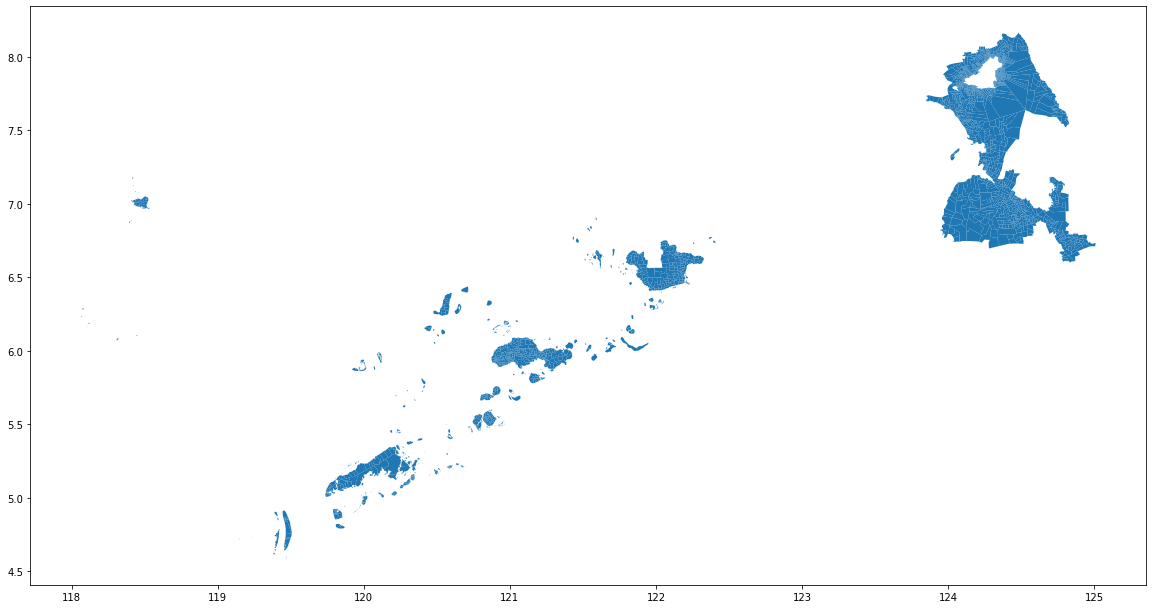

In [3]:
brgys_geodata.plot(figsize=(20,20))

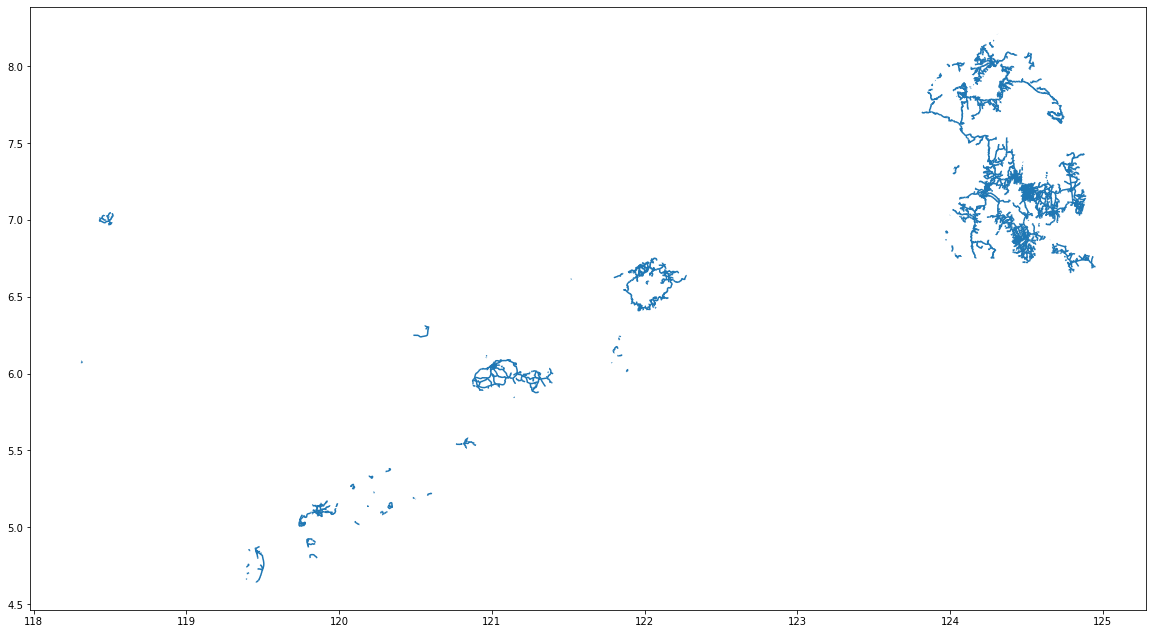

In [4]:
roads_geodata.plot(figsize=(20,20))

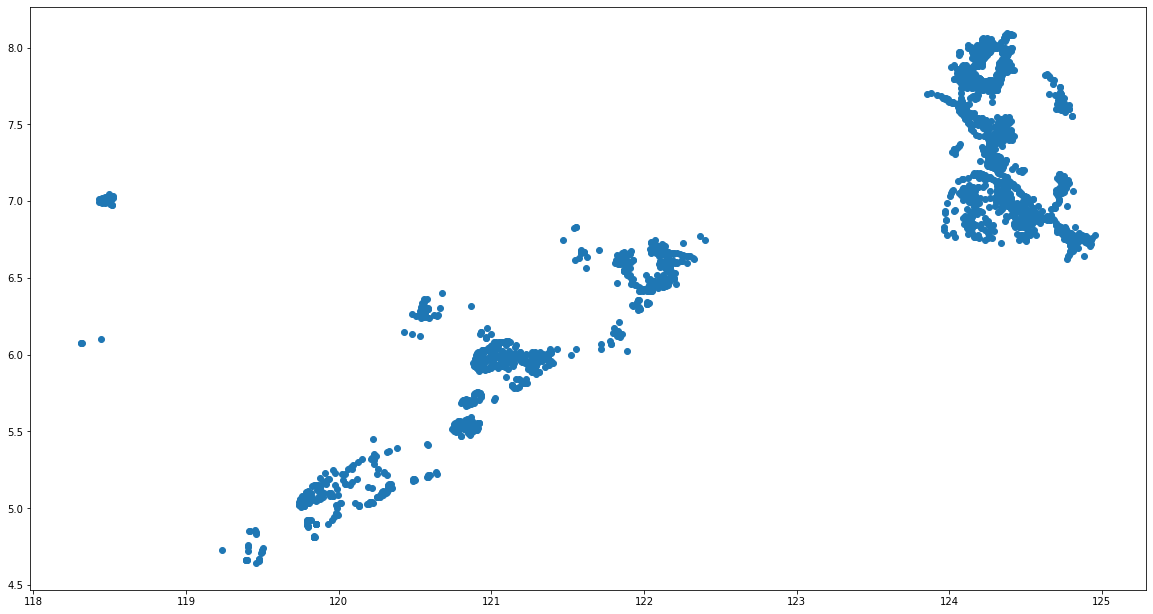

In [5]:
cond = (schools_geodata["geometry"].x==0) & (schools_geodata["geometry"].x==0)
schools_geodata = schools_geodata[~cond]
schools_geodata.plot(figsize=(20,20))